In [2]:
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import StandardScaler
import numpy as np

import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, cross_val_score, validation_curve
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import time
from matplotlib import cm
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [3]:
rice_cammeo_and_osmancik = fetch_ucirepo(id=545)

X = rice_cammeo_and_osmancik.data.features
y = rice_cammeo_and_osmancik.data.targets


print(rice_cammeo_and_osmancik.metadata) 
  

print(rice_cammeo_and_osmancik.variables) 

{'uci_id': 545, 'name': 'Rice (Cammeo and Osmancik)', 'repository_url': 'https://archive.ics.uci.edu/dataset/545/rice+cammeo+and+osmancik', 'data_url': 'https://archive.ics.uci.edu/static/public/545/data.csv', 'abstract': "A total of 3810 rice grain's images were taken for the two species, processed and feature inferences were made. 7 morphological features were obtained for each grain of rice.", 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 3810, 'num_features': 7, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2019, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5MW4Z', 'creators': [], 'intro_paper': {'title': 'Classification of Rice Varieties Using Artificial Intelligence Methods', 'authors': 'Ilkay Cinar, M. Koklu', 'published_in': 'International Journal of Intelligent Systems and App

In [4]:
data = pd.concat([X, y], axis=1)

selected_data = data.sample(n=500, random_state=42)

X_selected = selected_data.drop(columns='Class')
y_selected = selected_data['Class']

In [5]:
le = LabelEncoder()
y_selected = le.fit_transform(y_selected)
print('the portion of Cammeo rice is ' + str(round(sum(y_selected) / len(y_selected) * 100,4)) + '%')
# The dataset is quite balanced.
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.2, stratify=y_selected, random_state=42)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

the portion of Cammeo rice is 54.2%


Data DESCR:

A total of 3810 rice grain's images were taken for the two species, processed and feature inferences were made. 7 morphological features were obtained for each grain of rice.

num_instances: 3810

num_features: 7

class: 2, Cammeo and Osmancik

data_url: https://archive.ics.uci.edu/static/public/545/data.csv

The selected data(500 samples) is balanced

In [6]:
# make f2 a valid validation
def f2_scorer(y_true, y_pred):
    y_true, y_pred, = np.array(y_true), np.array(y_pred)
    return fbeta_score(y_true, y_pred, beta = 2, pos_label = 0, average = 'binary')

f2 = make_scorer(f2_scorer, greater_is_better=True)

# here for question b: make f05 a valid validation
def f05_scorer(y_true, y_pred):
    y_true, y_pred, = np.array(y_true), np.array(y_pred)
    return fbeta_score(y_true, y_pred, beta = 0.5, pos_label = 0, average = 'binary')

f05 = make_scorer(f05_scorer, greater_is_better = True)

We choose f2 and f0.5 score as optimization objects, because we want to consider both precision and recall, and we also want to obeserve the trade off between them.

F2 score pays recall twice as important as presision, while f0.5 pays precision twice important as recall.

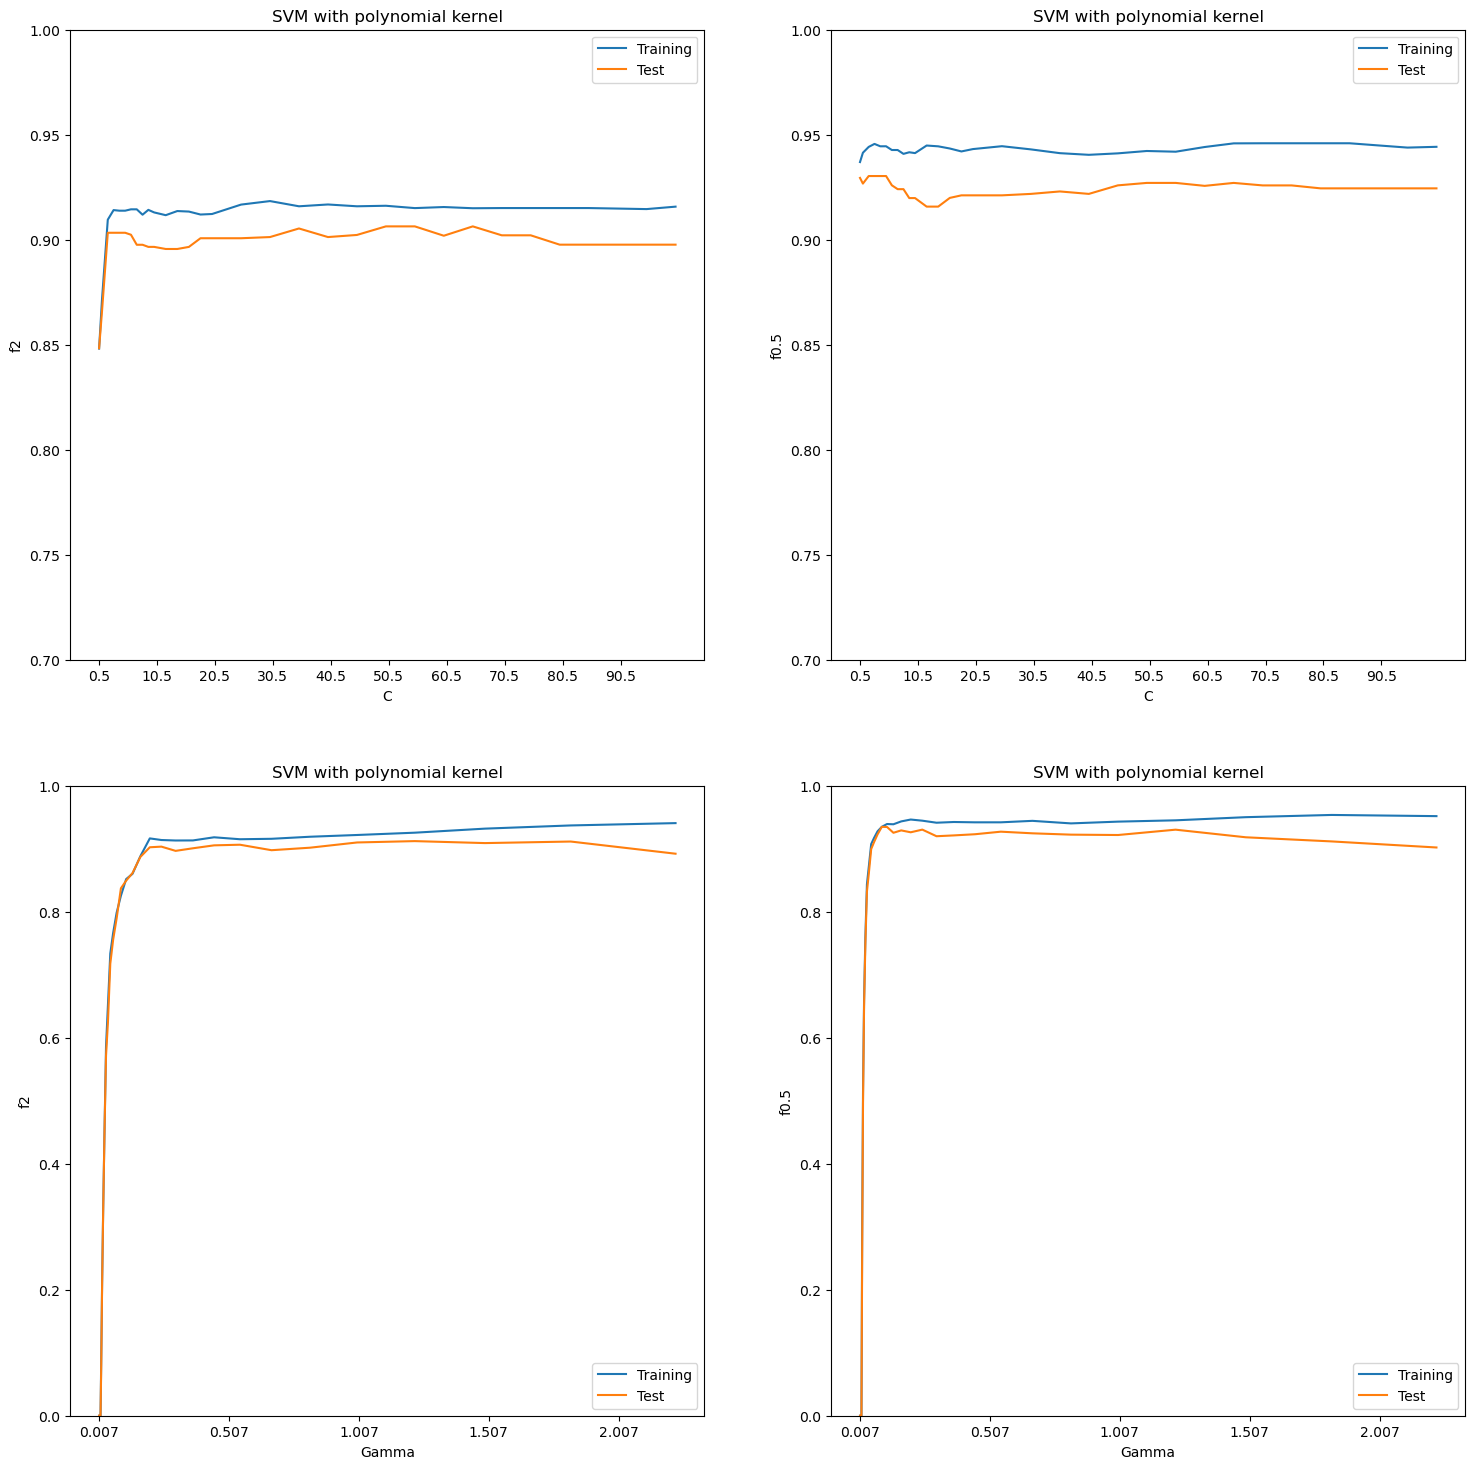

In [6]:
# SVM with polynomial kernel
# for score = f2 and f0.5
# hyperparameters gamma, C 
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
#
def plot_poly_curve(gammas = 'auto', Cs = 1, degrees = 3, scoring = f2): # by default
    
    num_splits = 5 # use of k-fold is good
    kfold = KFold(n_splits = 5) # ,random_state = 0) 
    
    if type(Cs) == np.ndarray:
        svm_poly = svm.SVC(kernel = 'poly', gamma = gammas, degree = degrees)
        num_values = len(Cs)
        train_scores, valid_scores = validation_curve(svm_poly, X_train, y_train, 
                                                  param_name="C", param_range=Cs, cv=kfold, 
                                                  scoring = scoring)
        xlabel = 'C'
        xtick = np.arange(Cs.min(), Cs.max(), 10)
        Xs = Cs
        ylim = [0.7, 1]
    elif type(gammas) == np.ndarray:
        svm_poly = svm.SVC(kernel = 'poly', degree = degrees, C = Cs)
        num_values = len(gammas)
        train_scores, valid_scores = validation_curve(svm_poly, X_train, y_train, 
                                                  param_name="gamma", param_range=gammas, cv=kfold, 
                                                  scoring = scoring)
        xlabel = 'Gamma'
        xtick = np.arange(gammas.min(), gammas.max(), 0.5)
        Xs = gammas
        ylim = [0, 1]
    else:
        raise TypeError

    train_scores_poly = pd.DataFrame(data = train_scores, 
                                        index = np.arange(0, num_values), 
                                        columns = np.arange(0, num_splits)) 
    valid_scores_poly = pd.DataFrame(data = valid_scores, 
                                        index = np.arange(0, num_values), 
                                        columns = np.arange(0, num_splits)) 

    plt.plot(Xs, train_scores_poly.mean(axis=1), label = 'Training')
    plt.plot(Xs, valid_scores_poly.mean(axis=1), label = 'Test')
    plt.xlabel(xlabel)
    if scoring == f2:
        plt.ylabel('f2')
    elif scoring == f05:
        plt.ylabel('f0.5')
    else:
        plt.ylabel('scoring')
    plt.ylim(ylim)
    plt.xticks(xtick)
    plt.title('SVM with polynomial kernel')
    plt.legend()

    
plt.figure(figsize = (18, 18))

Cs = np.append(np.array([0.5]), 
               np.append(np.append(np.arange(1, 10, 1), 
                                  
                                   np.arange(10, 20, 2)), 
                         np.arange(20, 101, 5)))

gammas = np.exp(np.arange(-5, 1, 0.2))

plt.subplot(2, 2, 1)
plot_poly_curve(Cs = Cs)
plt.subplot(2, 2, 2)
plot_poly_curve(Cs = Cs, scoring = f05)
plt.subplot(2, 2, 3)
plot_poly_curve(gammas = gammas)
plt.subplot(2, 2, 4)
plot_poly_curve(gammas = gammas, scoring = f05)

plt.show()

For both kernels, the models preform relatively better, when C is small(high degree of regulirazation)

For polynomial kernel, the model preforms bad, when gamma is small(underfitting). The performance gets better with increase of gamma at beginning. But large gamma will result in overfiiting, so at the end, when gamma is large, there is higher score ein traning data but lower score in test data due to overfitting.

But for rbf kernel, there is no distinct and strong influence of gamma.

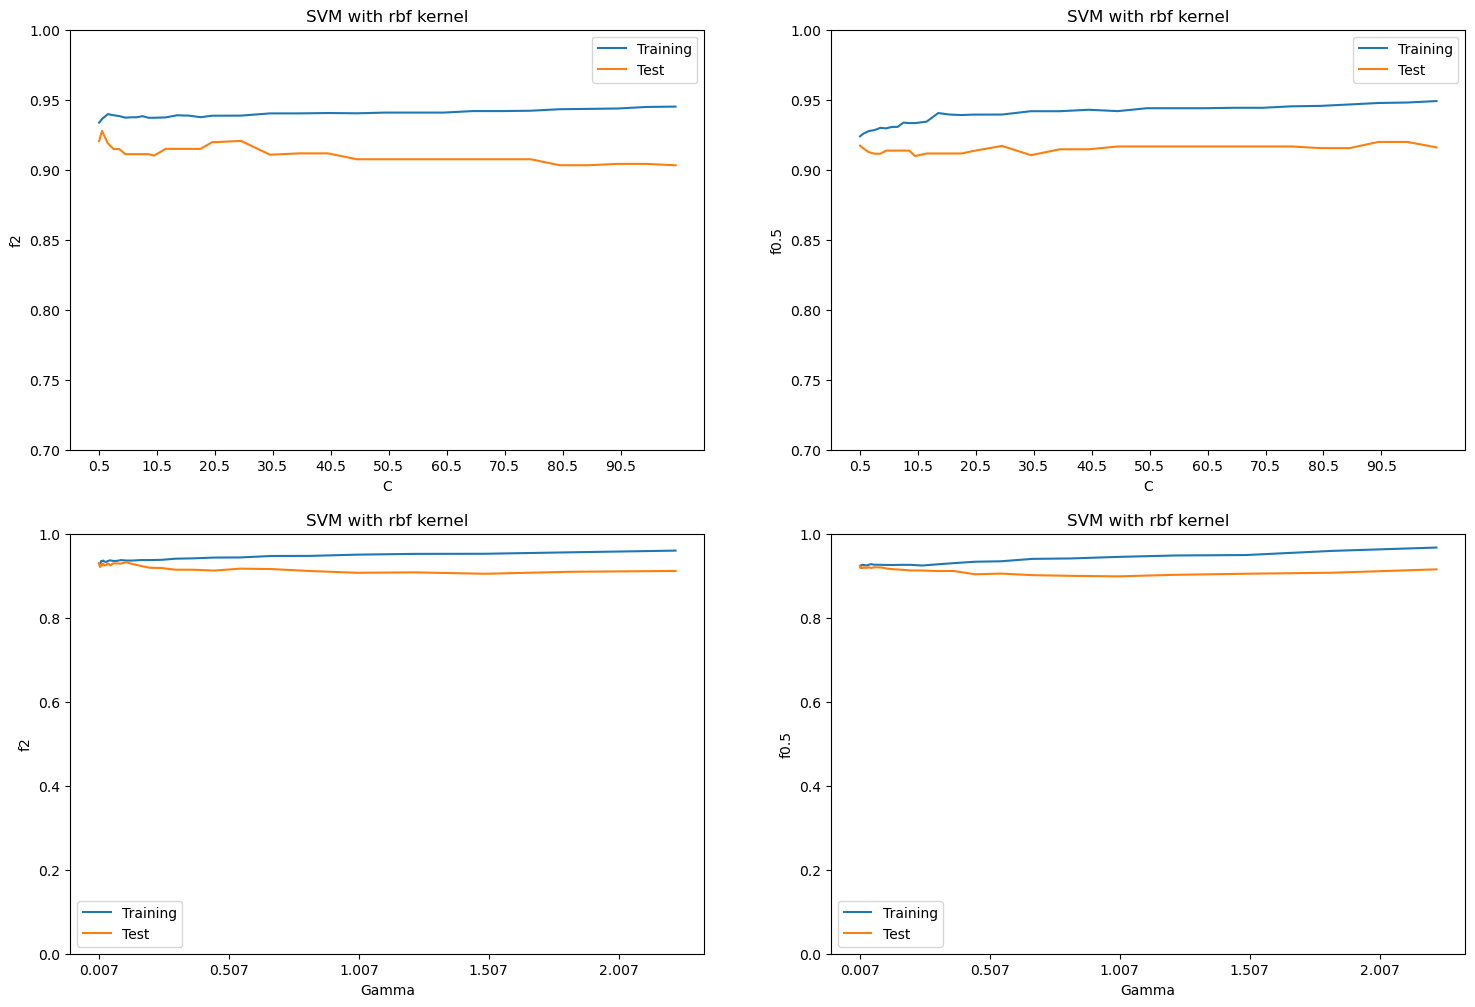

In [7]:

def plot_rbf_curve(gammas = 'auto', Cs = 1, scoring = f2): # by default
    
    num_splits = 5 # use of k-fold is good
    kfold = KFold(n_splits = 5) # ,random_state = 0) 
    
    if type(Cs) == np.ndarray:
        svm_poly = svm.SVC(kernel = 'rbf', gamma = gammas)
        num_values = len(Cs)
        train_scores, valid_scores = validation_curve(svm_poly, X_train, y_train, 
                                                  param_name="C", param_range=Cs, cv=kfold, 
                                                  scoring = scoring)
        xlabel = 'C'
        xtick = np.arange(Cs.min(), Cs.max(), 10)
        Xs = Cs
        ylim = [0.7, 1]
    elif type(gammas) == np.ndarray:
        svm_poly = svm.SVC(kernel = 'rbf', C = Cs)
        num_values = len(gammas)
        train_scores, valid_scores = validation_curve(svm_poly, X_train, y_train, 
                                                  param_name="gamma", param_range=gammas, cv=kfold, 
                                                  scoring = scoring)
        xlabel = 'Gamma'
        xtick = np.arange(gammas.min(), gammas.max(), 0.5)
        Xs = gammas
        ylim = [0, 1]
    else:
        raise TypeError

    train_scores_poly = pd.DataFrame(data = train_scores, 
                                        index = np.arange(0, num_values), 
                                        columns = np.arange(0, num_splits)) 
    valid_scores_poly = pd.DataFrame(data = valid_scores, 
                                        index = np.arange(0, num_values), 
                                        columns = np.arange(0, num_splits)) 

    plt.plot(Xs, train_scores_poly.mean(axis=1), label = 'Training')
    plt.plot(Xs, valid_scores_poly.mean(axis=1), label = 'Test')
    plt.xlabel(xlabel)
    if scoring == f2:
        plt.ylabel('f2')
    elif scoring == f05:
        plt.ylabel('f0.5')
    else:
        plt.ylabel('scoring')
    plt.ylim(ylim)
    plt.xticks(xtick)
    plt.title('SVM with rbf kernel')
    plt.legend()

    
plt.figure(figsize = (18, 12))

Cs = np.append(np.array([0.5]), 
               np.append(np.append(np.arange(1, 10, 1), 
                                  
                                   np.arange(10, 20, 2)), 
                         np.arange(20, 101, 5)))
#gammas = np.arange(0.008, 0.051, 0.002)
gammas = np.exp(np.arange(-5, 1, 0.2))

plt.subplot(2, 2, 1)
plot_rbf_curve(Cs = Cs)
plt.subplot(2, 2, 2)
plot_rbf_curve(Cs = Cs, scoring = f05)
plt.subplot(2, 2, 3)
plot_rbf_curve(gammas = gammas)
plt.subplot(2, 2, 4)
plot_rbf_curve(gammas = gammas, scoring = f05)

plt.show()

In [8]:
start = time.time()

param_grid = {'kernel' : ['poly', 'rbf'],
              'C' : [0.001, 0.01, 0.1, 0.5, 1, 10, 50, 100],
              'gamma' : [1/X_train.shape[1], 0.01, 0.1, 1, 10]
              #'degree' : [2, 3, 4, 5, 7, 10]
              }              

scoring = {
    #'Accuracy' : 'accuracy',
           #'Precision' : 'precision', 
           #'recall' : 'recall',
           #'f1' : 'f1', 
           'f2' : f2,
           'f0.5' : f05
           }

svm_ = svm.SVC() #random_state = 0)
CV_svm = GridSearchCV(estimator = svm_, param_grid = param_grid, cv = 5, 
                      scoring = scoring, refit = 'f2')
CV_svm.fit(X_train, y_train)


time_spend = time.time() - start
print('time spent: ', time_spend)

time spent:  1157.394370317459


In [9]:
# a DataFrame to keep track of the results
params_ = CV_svm.cv_results_['params']
result = {k : [dic[k] for dic in params_] for k in params_[0]}
cln = ['kernel', 'C', 'gamma']

for i in [ 'f0.5', 'f2']:
    result['mean_test_' + i] = CV_svm.cv_results_['mean_test_' + i]
    result['std_test_' + i] = CV_svm.cv_results_['std_test_' + i]
    cln.append('mean_test_' + i)

results = pd.DataFrame(result)
#display(results)

In [10]:
results.loc[results.kernel == 'rbf', 'degree'] = np.nan
results.loc[results.kernel == 'poly', 'degree'] = np.nan

results.drop_duplicates(inplace = True) 
results_sorted2 = results.sort_values('mean_test_f2', ascending = False)
display(results_sorted2.loc[:,cln].head(10))

,kernel,C,gamma,mean_test_f0.5,mean_test_f2
45,rbf,1.0,0.100000,0.920616,0.926256
53,rbf,10.0,0.010000,0.916555,0.925257
73,rbf,100.0,0.010000,0.916181,0.924951
63,rbf,50.0,0.010000,0.916181,0.924951
21,rbf,0.1,0.142857,0.922488,0.922409
31,rbf,0.5,0.142857,0.918955,0.921591
35,rbf,0.5,0.100000,0.918955,0.921591
43,rbf,1.0,0.010000,0.918955,0.921591
41,rbf,1.0,0.142857,0.911237,0.919601
25,rbf,0.1,0.100000,0.921201,0.918050


In [12]:
display(results_sorted2.tail(10))

,C,gamma,kernel,mean_test_f0.5,std_test_f0.5,mean_test_f2,std_test_f2,degree
32,0.500,0.010000,poly,0.0,0.0,0.0,0.0,NaN
19,0.010,10.000000,rbf,0.0,0.0,0.0,0.0,NaN
9,0.001,10.000000,rbf,0.0,0.0,0.0,0.0,NaN
7,0.001,1.000000,rbf,0.0,0.0,0.0,0.0,NaN
5,0.001,0.100000,rbf,0.0,0.0,0.0,0.0,NaN
4,0.001,0.100000,poly,0.0,0.0,0.0,0.0,NaN
3,0.001,0.010000,rbf,0.0,0.0,0.0,0.0,NaN
2,0.001,0.010000,poly,0.0,0.0,0.0,0.0,NaN
1,0.001,0.142857,rbf,0.0,0.0,0.0,0.0,NaN
22,0.100,0.010000,poly,0.0,0.0,0.0,0.0,NaN


For top ten mean f2 score, rbf kernel are dominated means it performs much more better than polynomial kernel for this dataset. and gamma is relatively small from 0.01 to 1. C is relatively larger(less regularization) 

For the worst ten mean f2 score, C is very small, much less than 1,while gamma still small. Hence, C plays more important role here

In [11]:
results.loc[results.kernel == 'rbf', 'degree'] = np.nan
results.loc[results.kernel == 'poly', 'degree'] = np.nan

results.drop_duplicates(inplace = True) 
results_sorted2 = results.sort_values('mean_test_f0.5', ascending = False)
display(results_sorted2.loc[:,cln].head(10))

,kernel,C,gamma,mean_test_f0.5,mean_test_f2
23,rbf,0.100,0.010000,0.942510,0.910895
54,poly,10.000,0.100000,0.932731,0.904600
16,poly,0.010,1.000000,0.932731,0.904600
60,poly,50.000,0.142857,0.929977,0.908254
40,poly,1.000,0.142857,0.929141,0.869458
6,poly,0.001,1.000000,0.928985,0.843791
44,poly,1.000,0.100000,0.928985,0.843791
26,poly,0.100,1.000000,0.928503,0.903355
74,poly,100.000,0.100000,0.928503,0.903355
50,poly,10.000,0.142857,0.928089,0.903275


In [13]:
display(results_sorted2.tail(10))

,C,gamma,kernel,mean_test_f0.5,std_test_f0.5,mean_test_f2,std_test_f2,degree
32,0.500,0.010000,poly,0.0,0.0,0.0,0.0,NaN
19,0.010,10.000000,rbf,0.0,0.0,0.0,0.0,NaN
9,0.001,10.000000,rbf,0.0,0.0,0.0,0.0,NaN
7,0.001,1.000000,rbf,0.0,0.0,0.0,0.0,NaN
5,0.001,0.100000,rbf,0.0,0.0,0.0,0.0,NaN
4,0.001,0.100000,poly,0.0,0.0,0.0,0.0,NaN
3,0.001,0.010000,rbf,0.0,0.0,0.0,0.0,NaN
2,0.001,0.010000,poly,0.0,0.0,0.0,0.0,NaN
1,0.001,0.142857,rbf,0.0,0.0,0.0,0.0,NaN
22,0.100,0.010000,poly,0.0,0.0,0.0,0.0,NaN


For top ten mean f0.5 score, poly kernel are dominated. Gamma becomes larger(near 1/nfeatures(7)), plays more important role here than for f2 score. C is also relatively large here, still plays a role.

Take away:

The gamma parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. The gamma parameters can be seen as the inverse of the radius of influence of samples selected by the model as support vectors, while a smaller gamma value leads to a larger influence radius.

When gamma is small (i.e., large influence range), the model treats all samples as having similar influence ranges. This means that the decision boundary will be as smooth as possible, trying to maximize the margin between class A and class B. In our example, the decision boundary may become very smooth, attempting to find the largest possible margin between class A and class B.
When gamma is large (i.e., small influence range), the model focuses more on the data near individual sample points. This means that the decision boundary may adapt more to the noise or local features in the data. In our example, the decision boundary may become more curved, trying to maximize the margin near each sample point in the dataset.

The C parameter trades off correct classification of training examples against maximization of the decision function’s margin. For larger values of C, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy. In other words C behaves as a regularization parameter in the SVM.

In [13]:
start = time.time()

C2 = np.append(np.array([0.5]),  
               np.append(np.append(np.arange(1, 10, 1), 
                                  
                                   np.arange(10, 20, 2)), 
                         np.arange(20, 101, 5)))

param_grid2 = {'C' : C2,
               'gamma' : np.append(np.arange(0.008, 0.051, 0.002), 1/X_train.shape[1])}   
scoring = { 
           'f2' : f2,
           'f0.5' : f05
           }

svm_2 = svm.SVC(kernel = 'rbf', random_state = 0)
CV_svm2 = GridSearchCV(estimator = svm_2, param_grid = param_grid2, cv = 5, 
                       scoring = scoring, refit = 'f2')
CV_svm2.fit(X_train, y_train)

time_spend = time.time() - start
print('time spent: ', time_spend)

time spent:  24.404562950134277


In [12]:
# a DataFrame to keep track of the results
params_2 = CV_svm2.cv_results_['params']
result2 = {k : [dic[k] for dic in params_2] for k in params_2[0]}

for i in [ 'f2', 'f0.5']:
    result2['mean_test_' + i] = CV_svm2.cv_results_['mean_test_' + i]
    result2['std_test_' + i] = CV_svm2.cv_results_['std_test_' + i]

results2 = pd.DataFrame(result2)

results_all = results.append(results2, ignore_index = True)

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [11]:
start = time.time()

C2 = np.append(np.array([0.5]),  
               np.append(np.append(np.arange(1, 10, 1), 
                                  
                                   np.arange(10, 20, 2)), 
                         np.arange(20, 101, 5)))

param_grid2 = {'C' : C2,
               'gamma' : np.append(np.arange(0.008, 0.051, 0.002), 1/X_train.shape[1])}   

svm_2 = svm.SVC(kernel = 'poly', random_state = 0)
CV_svm2 = GridSearchCV(estimator = svm_2, param_grid = param_grid2, cv = 5, 
                       scoring = f05, refit = 'f2')
CV_svm2.fit(X_train, y_train)

time_spend = time.time() - start
print('time spent: ', time_spend)

KeyboardInterrupt: 

In [ ]:
start = time.time()

param_grid = {'kernel' : ['poly', 'rbf'],
              'C' : [0.001, 0.01, 0.1, 0.5, 1, 10, 50, 100],
              'gamma' : [1/X_train.shape[1], 0.01, 0.1, 1, 10]
              #'degree' : [2, 3, 4, 5, 7, 10]
              }              

scoring = {
           'f2' : f2,
           'f0.5' : f05
           }

svm_ = svm.SVC() #random_state = 0)
CV_svm = GridSearchCV(estimator = svm_, param_grid = param_grid, cv = 5, 
                      scoring = scoring, refit = 'f2')
CV_svm.fit(X_train, y_train)


time_spend = time.time() - start
print('time spent: ', time_spend)